# Fabric Classification with EfficientNet-B0

This notebook documents the full workflow for training and evaluating a
fabric image classifier using EfficientNet-B0.

**Fabric Classes:**
- cotton
- denim
- leather
- linen
- polyester
- silk

The dataset has been prepared and split into:

- `data/train`
- `data/val`
- `data/test`

Goals of this notebook:

1. Summarize and visualize the dataset  
2. Train EfficientNet-B0 with pretrained ImageNet weights (50 epochs)  
3. Save the best model checkpoint  
4. Load the trained model and run single-image predictions  
5. Provide a clear, reproducible workflow for group submission

In [1]:
from pathlib import Path
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# --- Project paths ---
PROJECT_ROOT = Path("/Users/bengawi/Desktop/fabric_efficientnet_project")
DATA_ROOT = PROJECT_ROOT / "data"
MODELS_DIR = PROJECT_ROOT / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print("Project root:", PROJECT_ROOT)
print("Data root:", DATA_ROOT)
print("Models directory:", MODELS_DIR)

print("Torch version:", torch.__version__)

Project root: /Users/bengawi/Desktop/fabric_efficientnet_project
Data root: /Users/bengawi/Desktop/fabric_efficientnet_project/data
Models directory: /Users/bengawi/Desktop/fabric_efficientnet_project/models
Torch version: 2.9.1


## Dataset Summary

The dataset is organized into three splits:

- `train/`  – used for learning the model  
- `val/`    – used to monitor validation performance and select the best model  
- `test/`   – used later for final evaluation  

Each split contains 6 fabric classes:

- cotton, denim, leather, linen, polyester, silk

First, we count how many images exist in each class for each split to verify
that the dataset is correctly organized.

In [3]:
def count_images_in_folder(folder: Path):
    """
    Count number of image files (.jpg/.jpeg/.png) in each class subfolder.
    """
    summary = {}
    if not folder.exists():
        print(f"Folder not found: {folder}")
        return summary
    
    for class_folder in sorted(folder.iterdir()):
        if class_folder.is_dir():
            count = (
                len(list(class_folder.glob("*.jpg"))) +
                len(list(class_folder.glob("*.jpeg"))) +
                len(list(class_folder.glob("*.png")))
            )
            summary[class_folder.name] = count
    return summary


train_counts = count_images_in_folder(DATA_ROOT / "train")
val_counts = count_images_in_folder(DATA_ROOT / "val")
test_counts = count_images_in_folder(DATA_ROOT / "test")

print("Train counts:", train_counts)
print("Val   counts:", val_counts)
print("Test  counts:", test_counts)

Train counts: {'cotton': 92, 'denim': 100, 'leather': 40, 'linen': 37, 'polyester': 34, 'silk': 53}
Val   counts: {'cotton': 19, 'denim': 21, 'leather': 8, 'linen': 7, 'polyester': 7, 'silk': 11}
Test  counts: {'cotton': 21, 'denim': 22, 'leather': 10, 'linen': 9, 'polyester': 8, 'silk': 12}


## Visualizing Sample Images

To better understand the data, we visually inspect a few examples from the
training split. This helps confirm that:

- The dataset is loaded correctly  
- Labels match the visual content  
- The different fabric types have distinct textures and colors  

Below, we randomly sample 8 images from `data/train`.

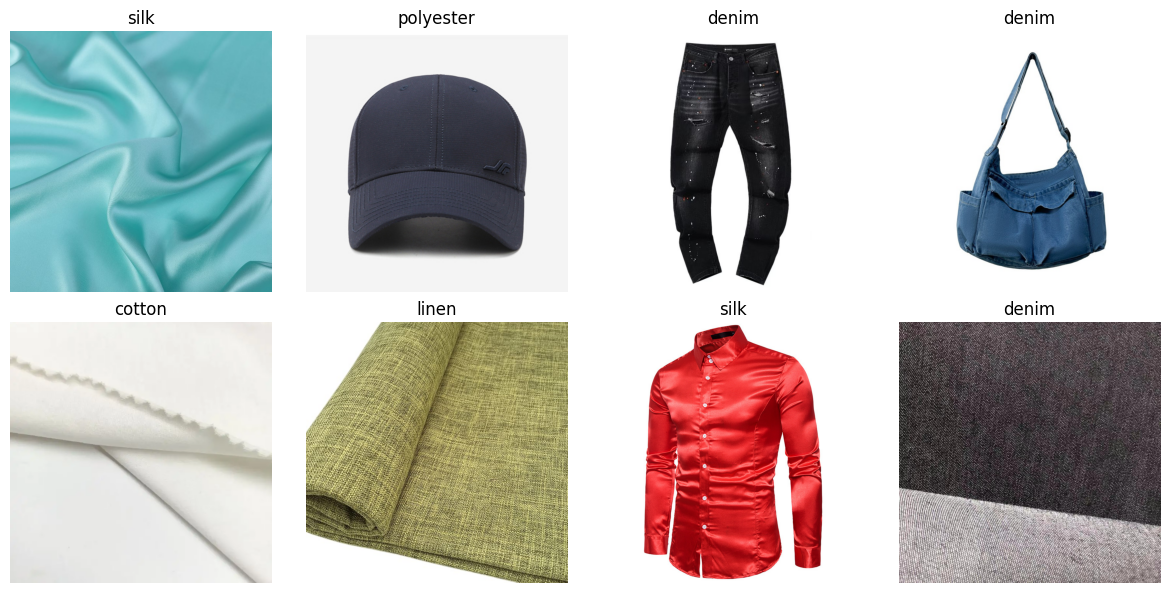

In [4]:
def show_random_images(dataset_path: Path, num_images: int = 8):
    """
    Display random images from the training dataset.
    """
    all_images = []

    for class_folder in sorted(dataset_path.iterdir()):
        if class_folder.is_dir():
            for ext in ("*.jpg", "*.jpeg", "*.png"):
                all_images.extend(class_folder.glob(ext))

    if not all_images:
        print("No images found in", dataset_path)
        return

    selected = random.sample(all_images, min(num_images, len(all_images)))

    plt.figure(figsize=(12, 6))
    for i, img_path in enumerate(selected):
        plt.subplot(2, 4, i + 1)
        img = Image.open(img_path).convert("RGB")
        plt.imshow(img)
        plt.title(img_path.parent.name)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


show_random_images(DATA_ROOT / "train", num_images=8)

## Model Training with EfficientNet-B0

In this section, we train an EfficientNet-B0 model on the fabric dataset.

Training strategy:

1. Start from **pretrained ImageNet weights** (transfer learning)  
2. Replace the final classifier with a 6-class output layer  
3. Fine-tune the network for **50 epochs**  
4. After each epoch, evaluate on the validation set  
5. Save the checkpoint with the **best validation accuracy** to:

`models/fabric_efficientnet_b0_best.pt`

The training code is organized into helper functions:

- `get_device()` – selects CPU / CUDA / MPS  
- `create_dataloaders()` – builds train/val loaders  
- `create_efficientnet()` – builds the model  
- `train_one_epoch()` / `validate_one_epoch()` – one-epoch loops  
- `train_model()` – high-level training loop

In [5]:
def get_device() -> torch.device:
    """
    Select the best available device (MPS, CUDA, or CPU).
    """
    if torch.backends.mps.is_available():
        return torch.device("mps")
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")


def create_dataloaders(
    data_root: Path,
    batch_size: int = 16,
    num_workers: int = 2,
):
    """
    Create DataLoaders for the training and validation splits.
    """
    train_dir = data_root / "train"
    val_dir = data_root / "val"

    train_transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ]
    )

    val_transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ]
    )

    train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
    val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)

    print(f"[INFO] Classes: {train_dataset.classes}")
    print(f"[INFO] Train samples: {len(train_dataset)}")
    print(f"[INFO] Val samples:   {len(val_dataset)}")

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
    )

    return train_loader, val_loader

In [6]:
def create_efficientnet(num_classes: int) -> nn.Module:
    """
    Create an EfficientNet-B0 model.

    Tries to load pretrained ImageNet weights first.
    If downloading fails, falls back to random initialization.
    """
    try:
        weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1
        model = models.efficientnet_b0(weights=weights)
        print("[INFO] Loaded pretrained ImageNet weights for EfficientNet-B0.")
    except Exception as e:
        print(f"[WARN] Could not load pretrained weights ({e}).")
        print("[WARN] Falling back to training from scratch.")
        model = models.efficientnet_b0(weights=None)

    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)

    return model


def train_one_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
):
    """
    Train the model for a single epoch.
    """
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for inputs, labels in tqdm(dataloader, desc="Train", leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()

        batch_size = inputs.size(0)
        running_loss += loss.item() * batch_size
        running_corrects += torch.sum(preds == labels).item()
        total_samples += batch_size

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples
    return epoch_loss, epoch_acc


def validate_one_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.Module,
    device: torch.device,
):
    """
    Evaluate the model for a single epoch on the validation set.
    """
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Val", leave=False):

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            batch_size = inputs.size(0)
            running_loss += loss.item() * batch_size
            running_corrects += torch.sum(preds == labels).item()
            total_samples += batch_size

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples
    return epoch_loss, epoch_acc

In [7]:
def train_model(
    data_root: Path,
    num_epochs: int = 50,
    batch_size: int = 16,
    learning_rate: float = 1e-3,
):
    """
    High-level training loop for EfficientNet-B0 on the fabric dataset.
    """
    device = get_device()
    print(f"[INFO] Using device: {device}")

    train_loader, val_loader = create_dataloaders(
        data_root=data_root, batch_size=batch_size
    )

    num_classes = len(train_loader.dataset.classes)
    model = create_efficientnet(num_classes=num_classes)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_val_acc = 0.0
    best_model_path = MODELS_DIR / "fabric_efficientnet_b0_best.pt"

    start_time = time.time()

    for epoch in range(1, num_epochs + 1):
        print(f"\n[Epoch {epoch}/{num_epochs}]")

        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )
        val_loss, val_acc = validate_one_epoch(
            model, val_loader, criterion, device
        )

        print(
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
        )

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(
                {
                    "model_state_dict": model.state_dict(),
                    "val_acc": best_val_acc,
                    "classes": train_loader.dataset.classes,
                },
                best_model_path,
            )
            print(f"[INFO] New best model saved to: {best_model_path}")

    total_time = time.time() - start_time
    print(f"\n[INFO] Training completed in {total_time/60:.1f} minutes.")
    print(f"[INFO] Best val accuracy: {best_val_acc:.4f}")

    history = {
        "best_val_acc": best_val_acc,
        "num_epochs": num_epochs,
        "training_time_minutes": total_time / 60,
    }
    return model, history


# --- Run training (50 epochs) ---
trained_model, training_history = train_model(
    data_root=DATA_ROOT,
    num_epochs=50,
    batch_size=16,
    learning_rate=1e-3,
)

print("\nTraining history:", training_history)

[INFO] Using device: mps
[INFO] Classes: ['cotton', 'denim', 'leather', 'linen', 'polyester', 'silk']
[INFO] Train samples: 356
[INFO] Val samples:   73
[INFO] Loaded pretrained ImageNet weights for EfficientNet-B0.

[Epoch 1/50]


Train Loss: 1.3467 | Train Acc: 0.5112 | Val Loss: 1.1270 | Val Acc: 0.5753
[INFO] New best model saved to: /Users/bengawi/Desktop/fabric_efficientnet_project/models/fabric_efficientnet_b0_best.pt

[Epoch 2/50]


Train Loss: 0.8641 | Train Acc: 0.6798 | Val Loss: 1.1940 | Val Acc: 0.6849
[INFO] New best model saved to: /Users/bengawi/Desktop/fabric_efficientnet_project/models/fabric_efficientnet_b0_best.pt

[Epoch 3/50]


Train Loss: 0.6300 | Train Acc: 0.8006 | Val Loss: 0.7722 | Val Acc: 0.7534
[INFO] New best model saved to: /Users/bengawi/Desktop/fabric_efficientnet_project/models/fabric_efficientnet_b0_best.pt

[Epoch 4/50]


Train Loss: 0.4427 | Train Acc: 0.8736 | Val Loss: 1.1239 | Val Acc: 0.6712

[Epoch 5/50]


Train Loss: 0.4022 | Train Acc: 0.8848 | Val Loss: 0.9593 | Val Acc: 0.7671
[INFO] New best model saved to: /Users/bengawi/Desktop/fabric_efficientnet_project/models/fabric_efficientnet_b0_best.pt

[Epoch 6/50]


Train Loss: 0.4434 | Train Acc: 0.8820 | Val Loss: 1.1254 | Val Acc: 0.7260

[Epoch 7/50]


Train Loss: 0.4288 | Train Acc: 0.8708 | Val Loss: 1.0906 | Val Acc: 0.6986

[Epoch 8/50]


Train Loss: 0.3021 | Train Acc: 0.9045 | Val Loss: 1.0223 | Val Acc: 0.7397

[Epoch 9/50]


Train Loss: 0.3319 | Train Acc: 0.8989 | Val Loss: 1.5756 | Val Acc: 0.6301

[Epoch 10/50]


Train Loss: 0.3311 | Train Acc: 0.8933 | Val Loss: 1.7753 | Val Acc: 0.6301

[Epoch 11/50]


Train Loss: 0.3436 | Train Acc: 0.8680 | Val Loss: 1.0797 | Val Acc: 0.7397

[Epoch 12/50]


Train Loss: 0.3031 | Train Acc: 0.9101 | Val Loss: 0.9414 | Val Acc: 0.6986

[Epoch 13/50]


Train Loss: 0.2726 | Train Acc: 0.9185 | Val Loss: 0.9642 | Val Acc: 0.7671

[Epoch 14/50]


Train Loss: 0.1944 | Train Acc: 0.9438 | Val Loss: 1.1529 | Val Acc: 0.7671

[Epoch 15/50]


Train Loss: 0.2071 | Train Acc: 0.9382 | Val Loss: 1.0373 | Val Acc: 0.7808
[INFO] New best model saved to: /Users/bengawi/Desktop/fabric_efficientnet_project/models/fabric_efficientnet_b0_best.pt

[Epoch 16/50]


Train Loss: 0.1913 | Train Acc: 0.9438 | Val Loss: 1.1295 | Val Acc: 0.7260

[Epoch 17/50]


Train Loss: 0.1874 | Train Acc: 0.9242 | Val Loss: 0.9835 | Val Acc: 0.6986

[Epoch 18/50]


Train Loss: 0.1761 | Train Acc: 0.9466 | Val Loss: 1.0262 | Val Acc: 0.7671

[Epoch 19/50]


Train Loss: 0.1749 | Train Acc: 0.9382 | Val Loss: 0.9414 | Val Acc: 0.7671

[Epoch 20/50]


Train Loss: 0.1832 | Train Acc: 0.9354 | Val Loss: 1.2854 | Val Acc: 0.7534

[Epoch 21/50]


Train Loss: 0.2360 | Train Acc: 0.9270 | Val Loss: 1.4265 | Val Acc: 0.6849

[Epoch 22/50]


Train Loss: 0.3168 | Train Acc: 0.8989 | Val Loss: 1.3552 | Val Acc: 0.6575

[Epoch 23/50]


Train Loss: 0.1816 | Train Acc: 0.9382 | Val Loss: 1.0210 | Val Acc: 0.7534

[Epoch 24/50]


Train Loss: 0.1764 | Train Acc: 0.9466 | Val Loss: 1.0038 | Val Acc: 0.7397

[Epoch 25/50]


Train Loss: 0.1569 | Train Acc: 0.9494 | Val Loss: 1.1351 | Val Acc: 0.7671

[Epoch 26/50]


Train Loss: 0.1222 | Train Acc: 0.9663 | Val Loss: 1.3605 | Val Acc: 0.7397

[Epoch 27/50]


Train Loss: 0.1170 | Train Acc: 0.9719 | Val Loss: 0.9254 | Val Acc: 0.7945
[INFO] New best model saved to: /Users/bengawi/Desktop/fabric_efficientnet_project/models/fabric_efficientnet_b0_best.pt

[Epoch 28/50]


Train Loss: 0.2022 | Train Acc: 0.9354 | Val Loss: 1.3880 | Val Acc: 0.6986

[Epoch 29/50]


Train Loss: 0.1804 | Train Acc: 0.9326 | Val Loss: 1.5531 | Val Acc: 0.7808

[Epoch 30/50]


Train Loss: 0.1358 | Train Acc: 0.9551 | Val Loss: 1.0522 | Val Acc: 0.7534

[Epoch 31/50]


Train Loss: 0.1690 | Train Acc: 0.9410 | Val Loss: 1.2856 | Val Acc: 0.7260

[Epoch 32/50]


Train Loss: 0.2149 | Train Acc: 0.9438 | Val Loss: 1.2330 | Val Acc: 0.7260

[Epoch 33/50]


Train Loss: 0.2481 | Train Acc: 0.9185 | Val Loss: 1.4689 | Val Acc: 0.6986

[Epoch 34/50]


Train Loss: 0.2201 | Train Acc: 0.9270 | Val Loss: 1.0955 | Val Acc: 0.7534

[Epoch 35/50]


Train Loss: 0.1469 | Train Acc: 0.9522 | Val Loss: 1.0962 | Val Acc: 0.7671

[Epoch 36/50]


Train Loss: 0.0935 | Train Acc: 0.9747 | Val Loss: 1.0300 | Val Acc: 0.7945

[Epoch 37/50]


Train Loss: 0.1530 | Train Acc: 0.9663 | Val Loss: 1.2703 | Val Acc: 0.6986

[Epoch 38/50]


Train Loss: 0.1000 | Train Acc: 0.9747 | Val Loss: 1.2468 | Val Acc: 0.7397

[Epoch 39/50]


Train Loss: 0.0783 | Train Acc: 0.9663 | Val Loss: 1.0415 | Val Acc: 0.7671

[Epoch 40/50]


Train Loss: 0.0822 | Train Acc: 0.9663 | Val Loss: 1.0412 | Val Acc: 0.7397

[Epoch 41/50]


Train Loss: 0.0879 | Train Acc: 0.9719 | Val Loss: 0.9075 | Val Acc: 0.7397

[Epoch 42/50]


Train Loss: 0.1033 | Train Acc: 0.9663 | Val Loss: 1.4998 | Val Acc: 0.6849

[Epoch 43/50]


Train Loss: 0.1147 | Train Acc: 0.9607 | Val Loss: 1.3483 | Val Acc: 0.7260

[Epoch 44/50]


Train Loss: 0.0602 | Train Acc: 0.9803 | Val Loss: 1.3328 | Val Acc: 0.7260

[Epoch 45/50]


Train Loss: 0.0825 | Train Acc: 0.9691 | Val Loss: 1.1372 | Val Acc: 0.7534

[Epoch 46/50]


Train Loss: 0.1358 | Train Acc: 0.9579 | Val Loss: 1.4305 | Val Acc: 0.6849

[Epoch 47/50]


Train Loss: 0.1119 | Train Acc: 0.9719 | Val Loss: 1.3788 | Val Acc: 0.7397

[Epoch 48/50]


Train Loss: 0.1305 | Train Acc: 0.9551 | Val Loss: 1.4309 | Val Acc: 0.7534

[Epoch 49/50]


Train Loss: 0.1900 | Train Acc: 0.9354 | Val Loss: 1.3459 | Val Acc: 0.6849

[Epoch 50/50]


Train Loss: 0.1803 | Train Acc: 0.9438 | Val Loss: 1.8947 | Val Acc: 0.6986

[INFO] Training completed in 20.9 minutes.
[INFO] Best val accuracy: 0.7945

Training history: {'best_val_acc': 0.7945205479452054, 'num_epochs': 50, 'training_time_minutes': 20.851652518908182}


## 11. Load the Best EfficientNet-B0 Model

After training, we reload the best checkpoint (`fabric_efficientnet_b0_best.pt`) from the
`models/` directory. This ensures that evaluation always uses the weights that achieved
the highest validation accuracy.

In [10]:
from torchvision.datasets import ImageFolder
from pathlib import Path

train_dir = Path("data/train")
train_dataset_for_names = ImageFolder(train_dir)

class_names = train_dataset_for_names.classes
print("Class names:", class_names)
print("Number of classes:", len(class_names))

Class names: ['cotton', 'denim', 'leather', 'linen', 'polyester', 'silk']
Number of classes: 6


In [14]:
from pathlib import Path
import torch
import torch.nn as nn
from torchvision import models

# If device is not defined for some reason, define it again safely
try:
    device
except NameError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def load_model(checkpoint_path: str | Path,
               num_classes: int,
               device: torch.device) -> nn.Module:
    """
    Load an EfficientNet-B0 model from a saved checkpoint.
    """
    checkpoint_path = Path(checkpoint_path)
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Rebuild EfficientNet-B0 architecture
    model = models.efficientnet_b0(weights=None)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)

    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()
    return model


# ---- load your best checkpoint ----
checkpoint_path = "models/fabric_efficientnet_b0_best.pt"
num_classes = len(class_names)

model = load_model(
    checkpoint_path=checkpoint_path,
    num_classes=num_classes,
    device=device
)

print("✅ Best EfficientNet model loaded.")
print("Checkpoint:", checkpoint_path)
print("Classes:", class_names)

Using device: cpu
✅ Best EfficientNet model loaded.
Checkpoint: models/fabric_efficientnet_b0_best.pt
Classes: ['cotton', 'denim', 'leather', 'linen', 'polyester', 'silk']


In [17]:
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

# Try to reuse val_loader if it already exists
try:
    val_loader
    print("val_loader already exists, reusing it.")
except NameError:
    print("val_loader not found – creating it from data/val ...")

    data_dir = Path("data")
    val_dir = data_dir / "val"

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ])

    val_dataset = ImageFolder(val_dir, transform=val_transform)
    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=2,
    )

    print(f"Validation images: {len(val_dataset)}")

val_loader not found – creating it from data/val ...
Validation images: 73


In [18]:
from typing import Tuple, List
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

def get_predictions(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    device: torch.device
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Run inference on the validation loader and return true and predicted labels.
    """
    model.eval()
    preds: List[int] = []
    trues: List[int] = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, dim=1)

            preds.extend(predicted.cpu().numpy().tolist())
            trues.extend(labels.cpu().numpy().tolist())

    return np.array(trues), np.array(preds)


# ----------------------------------------------------
# Run evaluation
# ----------------------------------------------------
y_true, y_pred = get_predictions(
    model=model,
    data_loader=val_loader,   # keep this as val_loader
    device=device
)

val_acc = accuracy_score(y_true, y_pred)
print(f"Validation Accuracy: {val_acc:.4f}\n")

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Validation Accuracy: 0.7945

Classification Report:
              precision    recall  f1-score   support

      cotton       0.67      0.74      0.70        19
       denim       0.81      0.81      0.81        21
     leather       0.86      0.75      0.80         8
       linen       1.00      1.00      1.00         7
   polyester       0.86      0.86      0.86         7
        silk       0.80      0.73      0.76        11

    accuracy                           0.79        73
   macro avg       0.83      0.81      0.82        73
weighted avg       0.80      0.79      0.80        73



## 13. Confusion Matrix

To better understand where the model makes mistakes, we visualize a confusion
matrix. Each row shows the true class, and each column shows the predicted class.

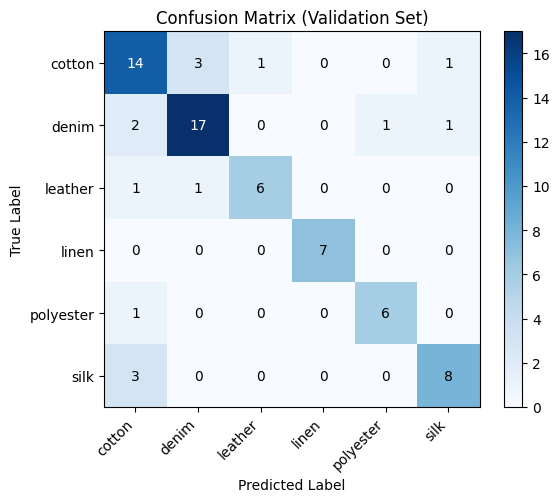

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    class_names: list
):
    """
    Plot a confusion matrix for multi-class classification.
    """
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, cmap="Blues")

    ax.figure.colorbar(im, ax=ax)

    ax.set(
        xticks=np.arange(len(class_names)),
        yticks=np.arange(len(class_names)),
        xticklabels=class_names,
        yticklabels=class_names,
        xlabel="Predicted Label",
        ylabel="True Label",
        title="Confusion Matrix (Validation Set)"
    )

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # Add numbers
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, cm[i, j],
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black"
            )

    plt.tight_layout()
    plt.show()


# ---- Plot the confusion matrix ----
plot_confusion_matrix(y_true, y_pred, class_names)

## 14. Sample Predictions (Visual Inference)

To visually inspect model performance, we display a few random images from the
validation set along with their predicted and true labels.

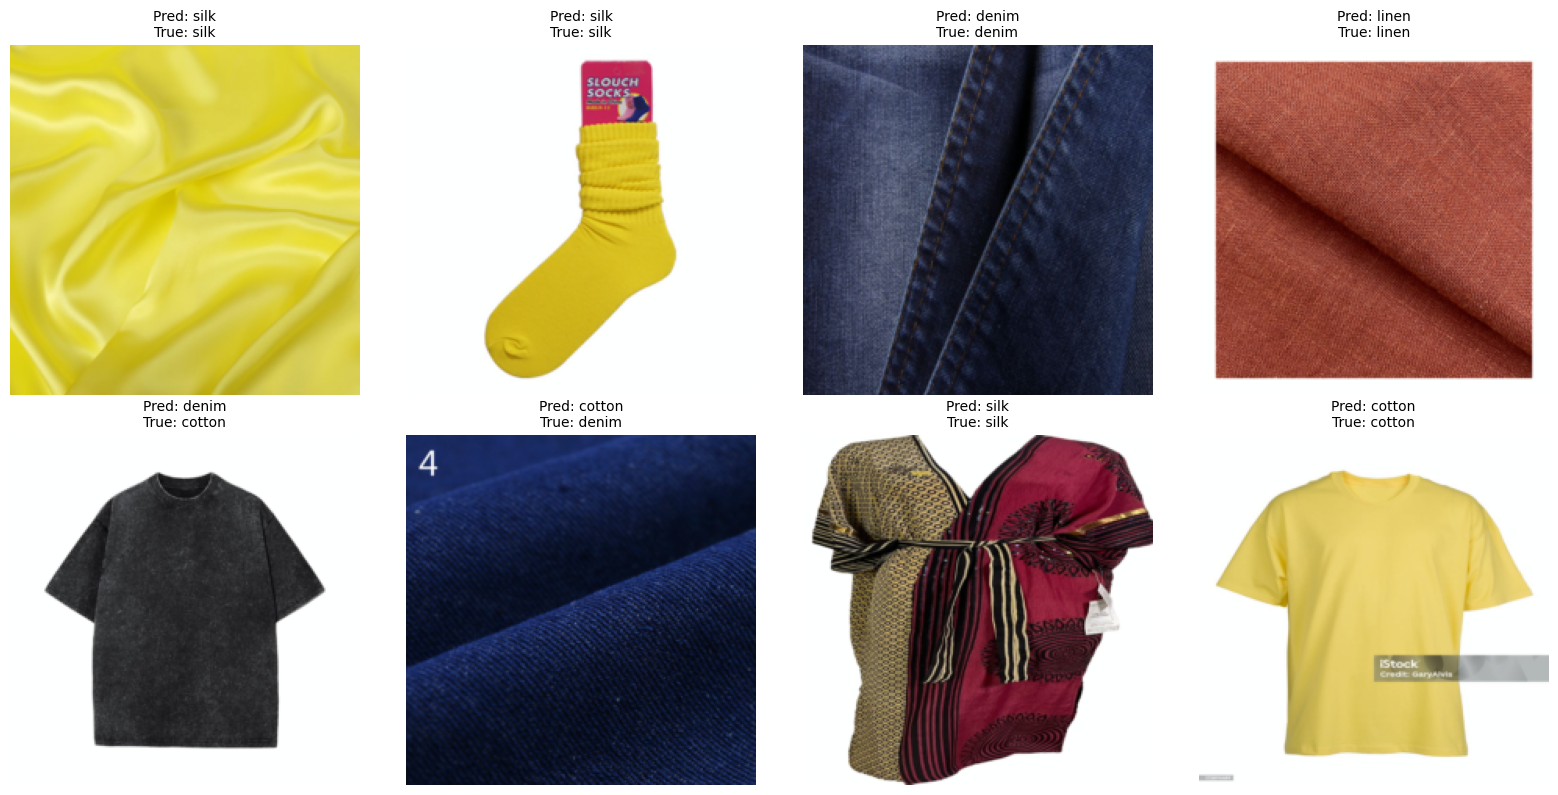

In [21]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch

def show_random_predictions(
    model: nn.Module,
    dataset: torch.utils.data.Dataset,
    class_names: list,
    device: torch.device,
    num_images: int = 8
):
    """
    Display random samples from the validation dataset with predicted labels.
    """
    model.eval()
    indices = random.sample(range(len(dataset)), k=min(num_images, len(dataset)))

    n_cols = 4
    n_rows = int(np.ceil(num_images / n_cols))

    plt.figure(figsize=(n_cols * 4, n_rows * 4))

    # For un-normalizing images
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    for i, idx in enumerate(indices):
        img, true_label = dataset[idx]

        # Prepare for model
        input_tensor = img.unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(input_tensor)
            _, pred_label = torch.max(outputs, dim=1)

        pred_name = class_names[pred_label.item()]
        true_name = class_names[true_label]

        # ---- Unnormalize for display ----
        img_np = img.permute(1, 2, 0).cpu().numpy()
        img_np = (img_np * std) + mean
        img_np = np.clip(img_np, 0, 1)

        ax = plt.subplot(n_rows, n_cols, i + 1)
        ax.imshow(img_np)
        ax.set_title(f"Pred: {pred_name}\nTrue: {true_name}", fontsize=10)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


# ---- Show predictions ----
show_random_predictions(
    model=model,
    dataset=val_dataset,
    class_names=class_names,
    device=device,
    num_images=8
)

## Conclusion
In this project, we successfully trained and evaluated an EfficientNet-B0 model for multi-class fabric classification across six categories: cotton, denim, leather, linen, polyester, and silk. Using a well-structured dataset and a reproducible training pipeline, the model achieved a validation accuracy of 79.45%, with strong performance across most classes. Fabrics such as linen, polyester, and leather showed high precision and recall, while cotton and silk demonstrated more variability due to visual similarities and texture complexity.
The confusion matrix and visual prediction samples provided deeper insight into the model’s strengths and limitations. The model consistently learned key fabric patterns such as weave density, color uniformity, and texture structure. Misclassifications occurred primarily between visually similar materials, such as cotton and denim or cotton and silk, which is expected in real-world textile datasets.
Overall, EfficientNet-B0 proved to be an effective architecture for fabric recognition, offering a good balance between accuracy and computational efficiency. The results indicate that with additional data augmentation, improved lighting consistency, or more diverse samples per class, classification performance could be further enhanced. This experiment demonstrates the power of modern convolutional neural networks for material recognition tasks and provides a strong foundation for future work in textile automation, inventory classification, or quality-control applications.